In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from nltk.corpus import stopwords
import spacy
from spacy.pipeline import SentenceSegmenter
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    
    text = re.sub(r'————', ' @SentBoundary@ ', text )
    
    # Spacy does not recognize: the double dash '--'. 
    text = re.sub(r'--', ' ',text)
    
    # Spacy thinks underscores are a new sentence
    text = re.sub('_', ' ', text)
    
    # Remove text between brackets
    text = re.sub('[\[][\S\s]*?[\]]', "", text)
    
    # Remove beginning of file Project Gutenberg info
    text = re.sub('[\S\s]*(ILLUSTRATED BY .*)', '', text)
    
    # Different format for beginning
    text = re.sub('[\S\s]*(Illustrated by .*)', '', text)
      
    # Remove Project Gutenberg end of file info
    text = re.sub('End of (the )*Project Gutenberg[\S\s]*', '', text, 1)
    
    # Remove Project Gutenberg end of file info
    text = re.sub('_Transcriber\'s note_[\S\s]*', '', text, 1)
    
    # Remove Project Gutenberg end of file info, different format
    text = re.sub('TRANSCRIBER\'S NOTE[\S\s]*', '', text, 1)
    
    # One text ends with the author name
    text = re.sub('=JACK McKENTY=[\S\s]*', '', text, 1)
    
    # Remove story section separators
    text = re.sub('(\s*\*){5}', ' @SentBoundary@ ', text)
    
    # No illustrators in these ones
    text = re.sub('[\S\s]*([Bb][Yy] L. J. STECHER, JR\.)', '', text, 1)
    text = re.sub('[\S\s]*(by Mack Reynolds)', '', text, 1)
    
    # Some texts end with END or THE END
    text = re.sub('\n(THE)* *(END)\n[\S\s]*', '', text, 1)
    
    # Some texts have roman numeral subdivisions, doesn't exceed III
    text = re.sub('\n[I]+\n', '\n\n', text)
    
    text = re.sub('[\n\r]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [3]:
def split_on_breaks(doc):
    start = 0
    seen_break = False
    for word in doc:
        if seen_break:
            yield doc[start:word.i-1]
            start = word.i
            seen_break = False
        elif word.text == '@SentBoundary@':
            seen_break = True
    if start < len(doc):
        yield doc[start:len(doc)]

sbd = SentenceSegmenter(nlp.vocab, strategy=split_on_breaks)
nlp.add_pipe(sbd, first=True)

#https://github.com/explosion/spaCy/issues/2791
#def get_sentences(text):
#    doc = nlp(text)
#    return (list(doc.sents))
#
#get_sentences("Bob meets Alice. @SentBoundary@ They play together.")

In [4]:
path = 'science_fiction/'
filelist = os.listdir(path)
sentences = []
file_num = 0

for x in filelist:
    if x.endswith('.txt'):
        file_num += 1
        try:
            with open(path + x, 'r') as file:
                text = file.read()
                text = text_cleaner(text)
                text_nlp = nlp(text)
                text_sents = [[sent, x[:-4], x[:-5]] for sent in text_nlp.sents]
                sentences += text_sents
                #print(text_sents)
        except:
            print('Failed Text: {}'.format(x))
            pass

In [5]:
# Combine the setnences from the two novels into one data frame
df = pd.DataFrame(sentences)
df.columns = ['text_sentences', 'text', 'author']
df.to_csv('scifi.csv')
df.head()

,text_sentences,text,author
0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick
1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick
2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick
3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick
4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick


In [6]:
df.shape

(358, 3)

In [7]:
# Add word and punctuation count
df[df['text_sentences'].apply(len)==0]

,text_sentences,text,author
166,(),pohl1,pohl
331,(),reynolds2,reynolds


In [8]:
# Fix two empy rows
df = df.drop([166, 331], axis=0).reset_index()
df.shape

(356, 4)

In [10]:
df['author'].unique()

array(['dick', 'quattrocchi', 'mckenty', 'pohl', 'leiber', 'harmon',
       'stetcher', 'ludwig', 'leinster', 'reynolds'], dtype=object)

In [11]:
# Convert to lemma
both_sents = [' '.join([token.lemma_ for token in sent]) for sent in df['text_sentences']]

# Convert to Part of speech
both_pos = [' '.join([token.pos_ for token in sent]) for sent in df['text_sentences']]


In [108]:
# lemma without names
both_no_people = [' '.join([token.lemma_ for token in sent if token.ent_type_ != 'PERSON']) 
                        for sent in df['text_sentences']]

In [12]:
vectorizer = CountVectorizer(max_features=2500, min_df=5, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(both_sents)
columns = list(vectorizer.get_feature_names())
print(columns[0:20])
print(X.toarray())  


['15th', 'abandon', 'ability', 'able', 'aboard', 'abruptly', 'absently', 'absolute', 'absolutely', 'absorb', 'academician', 'academy', 'acceleration', 'accent', 'accept', 'accident', 'accomplish', 'accord', 'account', 'ache']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [13]:
df_bow = pd.DataFrame(X.toarray(), columns=list(vectorizer.get_feature_names()))
df = df.join(df_bow)

In [16]:
vectorizer_pos = CountVectorizer()
X_pos = vectorizer_pos.fit_transform(both_pos)
columns_pos = list(vectorizer_pos.get_feature_names())
print(columns_pos[0:20])
print(X_pos.toarray())  

['adj', 'adp', 'adv', 'cconj', 'det', 'intj', 'noun', 'num', 'part', 'pron', 'propn', 'punct', 'sym', 'verb']
[[ 36  43  18 ...  48   0  63]
 [ 56  62  64 ... 261   0 175]
 [ 75 103  70 ... 242   0 187]
 ...
 [ 78  92  78 ... 164   0 187]
 [ 85  66  54 ... 157   0 124]
 [ 66  83  57 ... 175   0 142]]


In [17]:
df_pos = pd.DataFrame(X_pos.toarray(), columns=columns_pos)
df = df.join(df_pos, lsuffix='words', rsuffix='pos')

In [18]:
df.head()

,index,text_sentences,text,author,15th,abandon,ability,able,aboard,abruptly,...,det,intj,noun,num,part,pronpos,propn,punct,sym,verb
0,0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick,0,0,0,0,0,0,...,46,0,94,3,10,28,9,48,0,63
1,1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick,0,0,0,0,0,0,...,73,6,153,2,24,66,50,261,0,175
2,2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick,0,0,0,0,0,0,...,120,4,198,5,29,74,43,242,0,187
3,3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick,0,0,1,0,0,1,...,51,0,86,1,10,25,14,67,0,80
4,4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick,0,0,0,0,0,0,...,85,1,161,4,22,53,19,155,0,128


In [19]:
# Add word and punctuation count
df['word_count'] = df['text_sentences'].apply(len)-df['punct']

In [20]:
df['all_count'] = df['text_sentences'].apply(len)
df['all_caps'] = [sum([token.is_upper for token in sent]) for sent in df['text_sentences']]

In [21]:
df.head()

,index,text_sentences,text,author,15th,abandon,ability,able,aboard,abruptly,...,num,part,pronpos,propn,punct,sym,verb,word_count,all_count,all_caps
0,0,"(Ed, had, always, been, a, practical, man, ,, ...",dick2,dick,0,0,0,0,0,0,...,3,10,28,9,48,0,63,371,419,11
1,1,"("", Look, at, it, !, "", Loyce, snapped, ., "", ...",dick2,dick,0,0,0,0,0,0,...,2,24,66,50,261,0,175,751,1012,19
2,2,"("", Name, ?, "", the, cop, with, the, notebook,...",dick2,dick,0,0,0,0,0,0,...,5,29,74,43,242,0,187,934,1176,28
3,3,"(For, a, long, time, Loyce, watched, ,, crouch...",dick2,dick,0,0,1,0,0,1,...,1,10,25,14,67,0,80,391,458,3
4,4,"(Loyce, relaxed, a, little, ., He, studied, th...",dick2,dick,0,0,0,0,0,0,...,4,22,53,19,155,0,128,714,869,13


In [22]:
X_train, X_test, y_train, y_test = train_test_split(both_sents, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

vectorizer_tfidf = TfidfVectorizer(max_df=0.75, # drop words that occur in more than this % of paragraphs
                             min_df=5, # only use words that appear at least 5 times
                             #stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
tfidf = vectorizer_tfidf.fit_transform(both_sents)
print("Number of features: %d" % tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf = train_test_split(tfidf, test_size=0.25, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer_tfidf.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[1])
print('Tf_idf vector:', tfidf_bypara[1])

Number of features: 2681
Original sentence: on the second day follow -PRON- return to -PRON- room at tripler after breakfast , and find a honolulu city policeman sit hollow - eyed on the edge of -PRON- bed . the man stand up as chandler come in . " so , " -PRON- grumble , " -PRON- take so long ! here . be diagram , spec , part list , all . -PRON- get everything three day from now , then -PRON- begin . " the policeman , no longer koitska , shake -PRON- , glance stolidly at chandler and walk out , leave a thick manila envelope on the pillow . on -PRON- be write , in a crabbed hand : all secret ! do not show diagram ! chandler open the envelope and spill -PRON- content on the bed . an hour later -PRON- realize that sixty minute have pass in which -PRON- have not be afraid . -PRON- be good to be work again , -PRON- think , and then that thought fade away again as -PRON- return to study the sheaf of circuit diagram and closely type page of specification . -PRON- be not only work , -PRON- be

In [27]:
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(terms))

In [28]:
df_tfidf.head()

,15th,abandon,ability,able,aboard,about,above,abruptly,absently,absolute,...,yell,yellow,yes,yesterday,yet,york,young,youth,zone,zoroaster
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.029705,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.073945,0.000000,0.000000,0.0,...,0.0,0.031016,0.0,0.0,0.021093,0.0,0.00000,0.0,0.000000,0.0
3,0.0,0.0,0.069899,0.0,0.0,0.000000,0.000000,0.059547,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.014368,0.000000,0.000000,0.047601,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.02882,0.0,0.047601,0.0


In [ ]:
#Only run join once
#df_tfidf = df_tfidf.join(df_pos, lsuffix='tfidf', rsuffix='pos')
#df_tfidf['all_caps'] = df['all_caps']

In [29]:
df_tfidf.head()

,15th,abandon,ability,able,aboard,about,above,abruptly,absently,absolute,...,yell,yellow,yes,yesterday,yet,york,young,youth,zone,zoroaster
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.029705,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.073945,0.000000,0.000000,0.0,...,0.0,0.031016,0.0,0.0,0.021093,0.0,0.00000,0.0,0.000000,0.0
3,0.0,0.0,0.069899,0.0,0.0,0.000000,0.000000,0.059547,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.014368,0.000000,0.000000,0.047601,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.02882,0.0,0.047601,0.0


In [57]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_tfidf, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.


X_train_lsa = lsa.fit_transform(X_train2)
X_test_lsa = lsa.transform(X_test2)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {:.2f}".format(total_variance*100))

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
#paras_by_component=pd.DataFrame(X_train_lsa, index=X_train)
#for i in range(5):
#    print('Component {}:'.format(i))
#    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 90.59


In [80]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py



Cluster 0: captain torkel lieutenant fox gundy van garcia washington kelly sirians
Cluster 1: johnny ship would nordenfeld can quade will get this what
Cluster 2: tasso hendricks klaus hendrick bunker ash david come major claws
Cluster 3: burckhardt dorchin feckle swanson barth freezer mr robot dream wife
Cluster 4: chandler get craig what moklin could like know would look
Cluster 5: pa ma blanket nest air sis get would keep pail
Cluster 6: dr brinton harvey morton senator bed chime sleep get department
Cluster 7: loyce man cop hall store bus move car down get
Cluster 8: doc coffee casey martian know miss book dirty name hand
Cluster 9: charlie prone baxter accident would bronoski an if sir laura


In [77]:
svd.components_ 

array([[ 0.00587566,  0.00412973,  0.00448584, ...,  0.00404299,
         0.0022157 ,  0.00281275],
       [-0.00153965,  0.00331902, -0.00105986, ..., -0.00342417,
        -0.00031022, -0.00198764],
       [-0.00383786, -0.00211063,  0.00303477, ..., -0.00570754,
         0.00040105,  0.00116417],
       ...,
       [ 0.01410248,  0.02006278,  0.00421226, ..., -0.0041181 ,
        -0.02555831,  0.0002428 ],
       [-0.02363187,  0.00068321,  0.00598949, ..., -0.02246443,
        -0.01398809,  0.00329867],
       [ 0.03844789,  0.00722909, -0.01090599, ...,  0.02607777,
        -0.0125676 ,  0.00232075]])

In [58]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.02)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


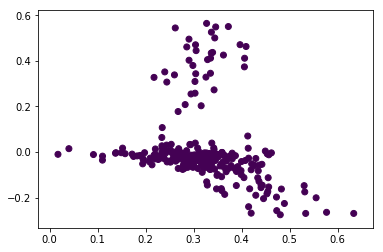

Comparing the assigned categories to the ones in the data:
col_0         0
author         
dick         43
harmon       29
leiber       14
leinster     24
ludwig       28
mckenty      11
pohl         59
quattrocchi  22
reynolds     22
stetcher     15


In [59]:
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:,1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train2,labels))

## Kmeans, 10 clusters

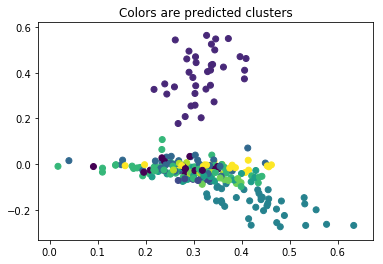

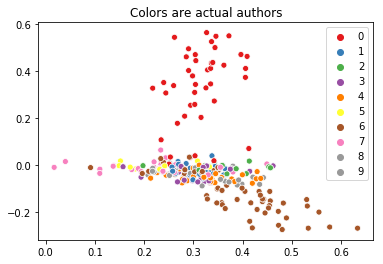

Comparing k-means clusters against the data:
col_0         0   1   2   3   4   5   6   7   8  9
author                                            
dick          0  35   0   7   0   0   1   0   0  0
harmon        0   0   0   3   0   0  16   0  10  0
leiber        0   0   0   0   0   0   5   0   0  9
leinster      0   0  15   0   0   0   1   0   0  8
ludwig        0   0   0   3   0  20   5   0   0  0
mckenty       0   0   0   9   0   0   2   0   0  0
pohl         19   0   0   0  38   0   2   0   0  0
quattrocchi   0   0   0  11   0   0  11   0   0  0
reynolds      0   0   0   0   0   0  11  11   0  0
stetcher      0   0   0   1   0   0  11   0   0  3

Crosstab with label encoded values.  Columns are clusters

col_0   0   1   2   3   4   5   6   7   8  9
row_0                                       
0       0  35   0   7   0   0   1   0   0  0
1       0   0   0   3   0   0  16   0  10  0
2       0   0   0   0   0   0   5   0   0  9
3       0   0  15   0   0   0   1   0   0  8
4       0   0

In [82]:
# Calculate predicted values.
km = KMeans(n_clusters=10)
y_pred = km.fit_predict(X_train_lsa)

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred)
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train2)
y_test_enc = le.fit_transform(y_test2)

sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train2, y_pred))
print('\nCrosstab with label encoded values.  Columns are clusters\n')
print(pd.crosstab(y_train_enc, y_pred))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train2, 
                                                                       y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                y_pred, 
                                                                metric='euclidean')))


In [86]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer_tfidf.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :12]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: burckhardt dorchin feckle swanson barth freezer mr robot dream wife door june
Cluster 1: tasso hendricks klaus hendrick bunker claws ash come david major down get
Cluster 2: nordenfeld jensen kathy ship queen chlorophage doctor passenger altaira air star would
Cluster 3: craig loyce dr get brinton what man know would boy will harvey
Cluster 4: chandler koitska exec body love could own no what know then man
Cluster 5: captain torkel lieutenant fox gundy van garcia washington kelly sirians taaleeb wiley
Cluster 6: would quade know can space time ship so alien what this will
Cluster 7: johnny mccord derek desage pierre mohammed goat sahara this tuareg hélène desert
Cluster 8: prone charlie baxter accident bronoski sir an prones if would position native
Cluster 9: moklin pa human get brooks caldwell inspector moklins just ma like blanket


# Part of Speech clustering

In [61]:
df_pos.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sym,verb,all_caps
0,36,43,18,21,46,0,94,3,10,28,9,48,0,63,11
1,56,62,64,20,73,6,153,2,24,66,50,261,0,175,19
2,75,103,70,26,120,4,198,5,29,74,43,242,0,187,28
3,26,55,24,19,51,0,86,1,10,25,14,67,0,80,3
4,89,84,42,26,85,1,161,4,22,53,19,155,0,128,13


In [62]:
df_pos['all_caps'] = df['all_caps']

## Means Shift

In [63]:
#Normalize POS data along feature axis to make up for shorter and longer passages
norm = Normalizer(norm='l2')
Xpos_norm = norm.fit_transform(df_pos)

X_train3, X_test3, y_train3, y_test3 = train_test_split(Xpos_norm, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

y_train_text, y_test_text = train_test_split(df['text'], test_size=0.3, random_state=0)

In [64]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train3, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train3)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


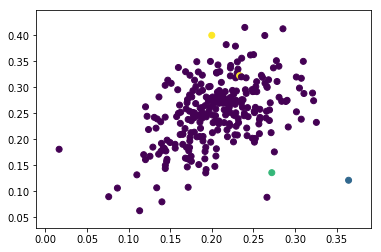

Comparing the assigned categories to the ones in the data:
col_0         0  1  2  3
author                  
dick         43  0  0  0
harmon       29  0  0  0
leiber       14  0  0  0
leinster     24  0  0  0
ludwig       28  0  0  0
mckenty      10  0  0  1
pohl         59  0  0  0
quattrocchi  19  1  1  1
reynolds     22  0  0  0
stetcher     15  0  0  0
Adjusted Rand Index: 0.00


In [48]:
plt.scatter(X_train3[:, 0], X_train3[:,1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train3,labels))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train3, labels)))

## KMeans

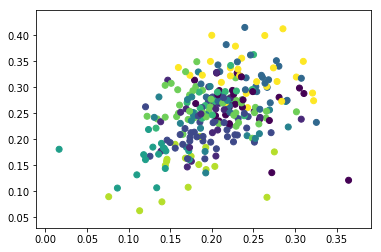

Comparing k-means clusters against the data:
col_0         0   1   2  3   4  5  6   7   8  9
author                                         
dick          3   2   4  0  13  7  0   1  10  3
harmon        2   1  10  5   0  1  4   4   1  1
leiber        0   0   1  8   0  0  5   0   0  0
leinster      4   0   3  1   0  0  4   7   0  5
ludwig        0   7   3  1   4  3  1   4   3  2
mckenty       0   0   0  1   2  0  0   5   0  3
pohl         11   1  15  8   2  2  1  14   0  5
quattrocchi   5   0   0  0   3  3  1   4   3  3
reynolds      4  10   1  0   1  0  0   2   0  4
stetcher      1   0   3  5   0  1  1   4   0  0
Adjusted Rand Index: 0.08
Silhouette Score: 0.13


In [199]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=10).fit_predict(X_train3)

# Plot the solution.
plt.scatter(X_train3[:, 0], X_train3[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train3, y_pred))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train3, 
                                                                       y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train3, 
                                                                y_pred, 
                                                                metric='euclidean')))


## Spectral

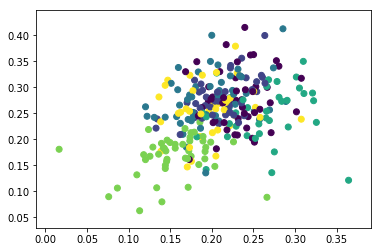

Comparing the assigned categories to the ones in the data:
col_0         0   1   2  3   4   5
author                            
dick          0   0  13  8  18   4
harmon       13   7   2  0   6   1
leiber        5   9   0  0   0   0
leinster      1  11   2  8   2   0
ludwig        4   1   3  6   5   9
mckenty       0   2   5  1   0   3
pohl         11  12  17  2  11   6
quattrocchi   1   2   9  4   5   1
reynolds      0   0   0  8   0  14
stetcher     14   0   0  0   1   0
Adjusted Rand Index: 0.10
Silhouette Score: 0.09


In [200]:
n_clusters=6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train3)

#Predicted clusters.
predict=sc.fit_predict(X_train3)

#Graph results.
plt.scatter(X_train3[:, 0], X_train3[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train3,predict))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train3, 
                                                                       predict)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train3, 
                                                                predict, 
                                                                metric='euclidean')))


# Part of Speech and TFIDF

In [ ]:
df.head()

In [ ]:
X_both = df.drop(['word_count', 'all_count', 'text_sentences', 'text', 'author', 'index'], axis=1)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_both, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa2 = lsa.fit_transform(X_train4)
X_test_lsa2 = lsa.transform(X_test4)


# Calculate predicted values.
y_pred2 = KMeans(n_clusters=10).fit_predict(X_train_lsa2)

# Plot the solution.
plt.scatter(X_train_lsa2[:, 0], X_train_lsa2[:, 1], c=y_pred2)
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train4)
y_test_enc = le.fit_transform(y_test4)

sns.scatterplot(X_train_lsa2[:, 0], X_train_lsa2[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Colors are actual authors')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train4, y_pred2))
print('\nCrosstab with label encoded values.  Columns are clusters\n')
print(pd.crosstab(y_train_enc, y_pred2))
print('Adjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train4, 
                                                                       y_pred2)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train4, 
                                                                y_pred2, 
                                                                metric='euclidean')))

# TFIDF - no names included

In [110]:
X_train_no_name, X_test_no_name, y_train_no_name, y_test_no_name = train_test_split(both_no_people, 
                                                                                    df['author'], 
                                                                                    test_size=0.25, 
                                                                                    random_state=0)

vect_tfidf_no_name = TfidfVectorizer(max_df=0.75, # drop words that occur in more than this % of paragraphs
                                     min_df=5, # only use words that appear at least 5 times
                                     stop_words=STOP_WORDS, 
                                     lowercase=True, #convert everything to lower case
                                     use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                     norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                     smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                    )


#Applying the vectorizer
tfidf2 = vect_tfidf_no_name.fit_transform(both_no_people)
print("Number of features: %d" % tfidf2.get_shape()[1])

#splitting into training and test sets
X_train_tfidf_no_name, X_test_tfidf_no_name = train_test_split(tfidf2, test_size=0.25, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr2 = X_train_tfidf_no_name.tocsr()

#number of paragraphs
n = X_train_tfidf_csr2.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vect_tfidf_no_name.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr2.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr2[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
#print('Original sentence:', X_train[1])
#print('Tf_idf vector:', tfidf_bypara[1])

Number of features: 2403


In [111]:
df_tfidf2 = pd.DataFrame(tfidf2.toarray(), columns=list(terms))

In [316]:
#Our SVD data reducer.  We are going to reduce the feature space.
svd2 = TruncatedSVD(200)
lsa = make_pipeline(svd2, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.


X_train_lsa2 = lsa.fit_transform(X_train_tfidf_no_name)
X_test_lsa2 = lsa.transform(X_test_tfidf_no_name)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {:.2f}".format(total_variance*100))

Percent variance captured by all components: 45.51


In [176]:
def k_means(n_cluster, Xtrain, ytrain, draw=False):
    # Calculate predicted values.
    km = KMeans(n_clusters=n_cluster)
    y_pred = km.fit_predict(Xtrain)

    if draw == True:
        # Plot the solution.
        plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=y_pred)
        plt.title('Colors are predicted clusters')
        plt.show()

    le = LabelEncoder()
    y_train_enc = le.fit_transform(ytrain)
   
    silhouette_score = metrics.silhouette_score(Xtrain, y_pred, metric='euclidean')
    ari_score = metrics.adjusted_rand_score(ytrain, y_pred)
            
    if draw == True:
        sns.scatterplot(Xtrain[:, 0], Xtrain[:, 1], hue=y_train_enc, legend='full', palette='Set1')
        plt.title('Colors are actual authors')
        plt.show()
        # Check the solution against the data.
        print('Comparing k-means clusters against the data:')
        print(pd.crosstab(y_train2, y_pred))
        print('\nCrosstab with label encoded values.  Columns are clusters\n')
        print(pd.crosstab(y_train_enc, y_pred))
        print('Adjusted Rand Index: {:.2f}'.format(ari_score))
        print('Silhouette Score: {:.2f}'.format(silhouette_score))
        
        # https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]

        terms = vectorizer_tfidf.get_feature_names()
        for i in range(n_cluster):
            print("Cluster %d:" % i, end='')
            for ind in order_centroids[i, :12]:
                print(' %s' % terms[ind], end='')
            print()
        
    return ari_score, silhouette_score


In [196]:
scores = []

# Cross validation for printing number of clusters
for cluster in range(2, 11):
    ari = []
    sil = []
    # Average scores over 5 models, cross-validate
    for i in range(1, 6):
        ari_new, sil_new = k_means(cluster, X_train_lsa2, ytrain=y_train_no_name, draw=False)
        ari.append(ari_new)
        sil.append(sil_new)
    ari_all = (np.mean(ari), np.std(ari))
    sil_all = (np.mean(sil), np.std(sil))
    scores.append((ari_all, sil_all, cluster))

scores.sort(reverse=True)

In [197]:
for score in scores[:5]:
    print(score)

((0.3475048710596352, 0.09186277177993342), (0.043590907472503646, 0.0015322905433290018), 8)
((0.3223755165906037, 0.07674642823277641), (0.04650985987554807, 0.0023330597504317785), 10)
((0.30882912130491313, 0.05989341757805513), (0.0467093787960718, 0.003466269375450395), 9)
((0.2519654632456775, 0.050189399052328526), (0.04075077092585192, 0.0026848288684379854), 7)
((0.2451521619051935, 0.09942962665150278), (0.03353851983076793, 0.0035628100596274944), 6)


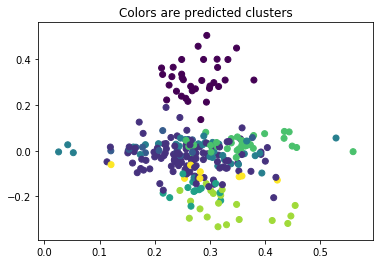

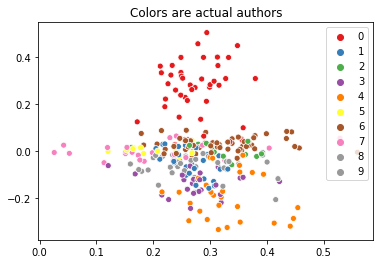

Comparing k-means clusters against the data:
col_0         0   1   2   3   4   5   6  7
author                                    
dick         33   5   0   4   0   1   0  0
harmon        0  28   0   1   0   0   0  0
leiber        0   4   0  10   0   0   0  0
leinster      0   1   0   2  13   0   0  8
ludwig        0   5   0   4   0   0  19  0
mckenty       0   1  10   0   0   0   0  0
pohl          0  15   3   7   0  34   0  0
quattrocchi   0  15   0   7   0   0   0  0
reynolds      0  22   0   0   0   0   0  0
stetcher      0  15   0   0   0   0   0  0

Crosstab with label encoded values.  Columns are clusters

col_0   0   1   2   3   4   5   6  7
row_0                               
0      33   5   0   4   0   1   0  0
1       0  28   0   1   0   0   0  0
2       0   4   0  10   0   0   0  0
3       0   1   0   2  13   0   0  8
4       0   5   0   4   0   0  19  0
5       0   1  10   0   0   0   0  0
6       0  15   3   7   0  34   0  0
7       0  15   0   7   0   0   0  0
8       0

(0.27572882239850993, 0.041305638747391016)

In [198]:
k_means(8, X_train_lsa2, ytrain=y_train_no_name, draw=True)

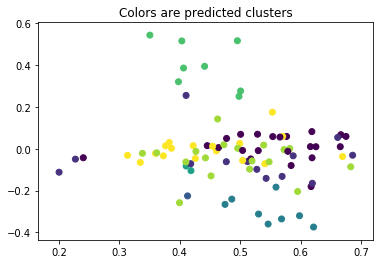

Comparing k-means clusters against the data:
col_0         0  1  2  3  4  5  6  7
author                              
dick          1  1  0  0  0  8  0  1
harmon        6  0  0  0  0  0  8  0
leiber        1  2  0  0  0  0  0  2
leinster      0  0  1  0  2  0  0  0
ludwig        2  2  0  8  0  0  0  0
mckenty       1  0  0  0  0  0  0  5
pohl         11  0  0  0  0  0  1  6
quattrocchi   0  3  0  0  0  0  6  3
reynolds      0  1  0  0  0  0  3  0
stetcher      0  4  0  0  0  0  0  0


In [205]:
km = KMeans(n_clusters=8)
km.fit(X_train_lsa2)
y_pred_test = km.predict(X_test_lsa2)


# Plot the solution.
plt.scatter(X_test_lsa2[:, 0], X_test_lsa2[:, 1], c=y_pred_test)
plt.title('Colors are predicted clusters')
plt.show()
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_test2, y_pred_test))

# Classifiers

## TFIDF, random forest

In [213]:
rfc = RandomForestClassifier(n_estimators=500)

train = rfc.fit(X_train_tfidf, y_train)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))

Training set score: 1.0

Test set score: 0.8539325842696629


## TFIDF, logistic regression

In [275]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_tfidf, 
                                                    df['author'], 
                                                    test_size=0.25, 
                                                    random_state=0)

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(50)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train2)
X_test_lsa = lsa.transform(X_test2)

Training set score: 0.9962546816479401

Test set score: 1.0


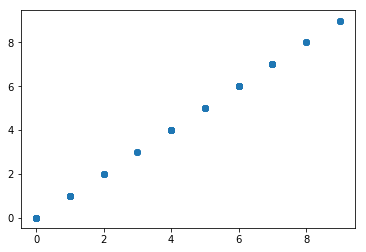

In [276]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', C=1.0)
y_train_enc = le.fit_transform(y_train2)
y_test_enc = le.transform(y_test2)
train = lr.fit(X_train_lsa, y_train_enc)

y_pred_lsa = lr.predict(X_test_lsa)

print('Training set score:', lr.score(X_train_lsa, y_train_enc))
print('\nTest set score:', lr.score(X_test_lsa, y_test_enc))

plt.scatter(y_pred_lsa, y_test_enc)
plt.show()

Training set score: 0.9887640449438202

Test set score: 0.9662921348314607


[]

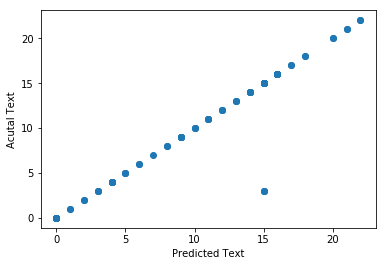

In [277]:
# Look at text instead of author, see if we can predict that
y_train6, y_test6 = train_test_split(df['text'], test_size=0.25, random_state=0)

y_train_enc = le.fit_transform(y_train6)
y_test_enc = le.transform(y_test6)


lr = LogisticRegression(solver='lbfgs', multi_class='ovr', C=1)
train = lr.fit(X_train_lsa, y_train_enc)
y_pred_lsa = lr.predict(X_test_lsa)

print('Training set score:', lr.score(X_train_lsa, y_train_enc))
print('\nTest set score:', lr.score(X_test_lsa, y_test_enc))

plt.scatter(y_pred_lsa, y_test_enc)
plt.xlabel('Predicted Text')
plt.ylabel('Acutal Text')
plt.plot()

In [256]:
 print('predicted text, actual text')
for i in range(len(y_pred_lsa)):
    predicted = y_pred_lsa[i]
    actual = y_test_enc[i]
    if predicted != actual:
        try:
            print('{} - {}'.format(list(le.inverse_transform([predicted]))[0], 
                               list(le.inverse_transform([actual]))[0]))
        except:
            print('Transform issue')

predicted text, actual text
pohl2 - ludwig3
pohl2 - harmon2
pohl2 - harmon2
pohl2 - harmon2


## Part of speech - logistic regression

Training set score: 0.3146067415730337

Test set score: 0.2808988764044944


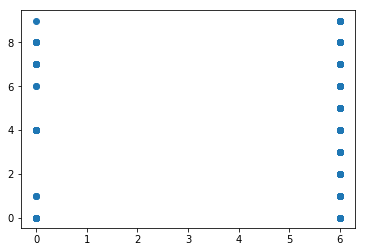

In [261]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
y_train_enc = le.fit_transform(y_train3)
y_test_enc = le.transform(y_test3)

train = lr.fit(X_train3, y_train_enc)

y_pred_pos_train = lr.predict(X_train3)
y_pred_pos = lr.predict(X_test3)

print('Training set score:', lr.score(X_train3, y_train_enc))
print('\nTest set score:', lr.score(X_test3, y_test_enc))

plt.scatter(y_pred_pos_train, y_train_enc)
plt.show()

Training set score: 0.8539325842696629

Test set score: 0.5842696629213483


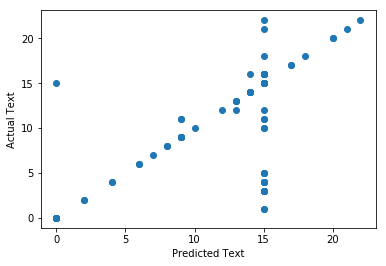

In [280]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')

train = lr.fit(X_train_lsa2, y_train_enc)

y_pred_pos_train = lr.predict(X_train_lsa2)
y_pred_pos = lr.predict(X_test_lsa2)

print('Training set score:', lr.score(X_train_lsa2, y_train_enc))
print('\nTest set score:', lr.score(X_test_lsa2, y_test_enc))

plt.scatter(y_pred_pos, y_test_enc)
plt.xlabel('Predicted Text')
plt.ylabel('Actual Text')
plt.show()

In [281]:
list(le.inverse_transform([15]))[0]

'pohl2'

In [283]:
(df['text']=='pohl2').sum()

53

In [285]:
rfc = RandomForestClassifier(n_estimators=500)

train = rfc.fit(X_train_lsa2, y_train)

print('Training set score:', rfc.score(X_train_lsa2, y_train))
print('\nTest set score:', rfc.score(X_test_lsa2, y_test))

Training set score: 1.0

Test set score: 0.7640449438202247


In [320]:
rfc.feature_importances_

array([0.01783232, 0.0768541 , 0.05573369, 0.05932187, 0.04311489,
       0.02627862, 0.04484815, 0.03117058, 0.02170541, 0.02645126,
       0.01453257, 0.01476282, 0.01632398, 0.01405683, 0.0124148 ,
       0.01168071, 0.01234878, 0.0084746 , 0.01005934, 0.00647878,
       0.00925135, 0.00555697, 0.00967138, 0.00923964, 0.00444719,
       0.00450202, 0.00463867, 0.00467232, 0.00498898, 0.00432679,
       0.00416295, 0.0027988 , 0.00399922, 0.00284934, 0.00477091,
       0.00356776, 0.00399111, 0.00365584, 0.00339253, 0.00235862,
       0.00284062, 0.00211364, 0.00284575, 0.00198901, 0.00270643,
       0.00257671, 0.00396644, 0.00354288, 0.00231926, 0.00219438,
       0.00303277, 0.00269824, 0.00372253, 0.00228635, 0.00189545,
       0.00264997, 0.00249605, 0.00292917, 0.00252478, 0.00232564,
       0.00312327, 0.00239737, 0.00276505, 0.00185265, 0.00220388,
       0.00191977, 0.00234844, 0.00358057, 0.0025025 , 0.00212588,
       0.00225287, 0.0022369 , 0.0028793 , 0.00291959, 0.00285

In [386]:
tfidf_indices = svd2.inverse_transform(indices.reshape(1, -1))

terms = vect_tfidf_no_name.get_feature_names()

#for ind in important_terms[0, :10]:
#    print('{} '.format(terms[ind]))

In [388]:
tfidf_indices

array([[ 59.04999431,  -3.96408228, -10.4677327 , ...,   0.33140849,
         23.21830551,  -7.03782257]])

Feature ranking:
1. feature 1 (0.07685410377584169) abandon
2. feature 3 (0.059321869795285725) able
3. feature 2 (0.055733690283890615) ability
4. feature 6 (0.04484815028990559) absently
5. feature 4 (0.04311489063001102) aboard
6. feature 7 (0.031170580073241222) absolute
7. feature 9 (0.026451264858685906) absorb
8. feature 5 (0.026278624142588042) abruptly
9. feature 8 (0.021705412285820045) absolutely
10. feature 0 (0.01783232195598319) 15th


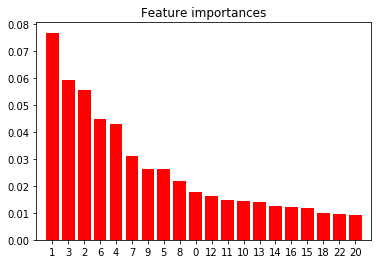

In [355]:
# Back to tfidf
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

terms = vect_tfidf_no_name.get_feature_names()

for f in range(10):
    print('{}. feature {} ({}) {}'.format((f+1), indices[f], importances[indices[f]], terms[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), indices)
plt.xlim([-1, 20])
plt.show()


In [356]:
len(terms)

2403